In [3]:
import sys
sys.path.append('..')
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from hamp_pred.external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

In [19]:
data[data.train_seq.str.contains('IRVLLRSISQVIGILGMRFNEM')]
mod.predict(['IRVLLRSISQVIGILGMRFNEM'])

1/1 [==============================] - 1s 1s/step


,id,external_id,sequence,N,C,lengths,linkers,N_pred,C_pred,predicted_rotation
0,0,None,IRVLLRSISQVIGILGMRFNEM,IRVLLRSISQV,IGILGMRFNEM,"[11, 11]",[0],"[[-9.03830337524414], [-8.443096160888672], [-...","[[-9.03830337524414], [-8.443096160888672], [-...","[[-9.03830337524414], [-8.443096160888672], [-..."


## Prepare data

In [11]:
DATA_DIR = '../data/input'
data = f'{DATA_DIR}/af2_true_full.balance.features.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)

## Train and validate

In [18]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)
model_conf = model_config = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 1,
    'reshape_out': False,
    'epochs': 100
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
mod = Predictor('hamp_rot', config=conf)
# trained = mod.train(data) 

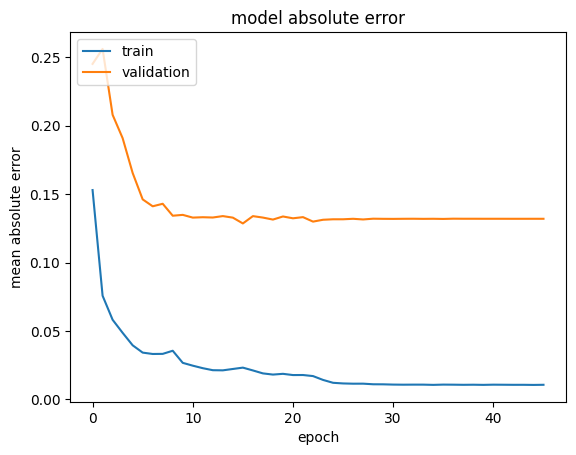

In [4]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

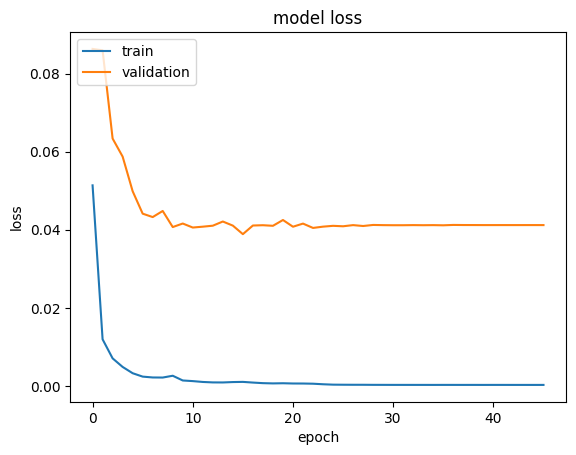

In [5]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validation set results 

In [7]:
val = data.loc[val_ids]
seqs = list(val.train_seq)
tr=[]
for n,r in val.iterrows():
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seqs)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

/var/folders/kd/py7h1wzs6vbgxk8yw70z36cm0000gn/T/ipykernel_95089/79076738.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]
2023-03-31 20:28:40.417175: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 [==============================] - 2s 68ms/step


In [8]:
res

,id,external_id,sequence,N,C,lengths,linkers,N_pred,C_pred,predicted_rotation
0,0,None,IRVLLRSISQVIGILGMRFNEM,IRVLLRSISQV,IGILGMRFNEM,"[11, 11]",[0],"[[-9.038305282592773], [-8.443095207214355], [...","[[-9.038305282592773], [-8.443095207214355], [...","[[-9.038305282592773], [-8.443095207214355], [..."
1,1,None,IIEISNLLSIAIKLLGESFNEM,IIEISNLLSIA,IKLLGESFNEM,"[11, 11]",[0],"[[-4.03725528717041], [-6.382399559020996], [-...","[[-4.03725528717041], [-6.382399559020996], [-...","[[-4.03725528717041], [-6.382399559020996], [-..."
2,2,None,INKLIDLMEQALAVLGNKFNNM,INKLIDLMEQA,LAVLGNKFNNM,"[11, 11]",[0],"[[1.32253098487854], [0.44494199752807617], [5...","[[1.32253098487854], [0.44494199752807617], [5...","[[1.32253098487854], [0.44494199752807617], [5..."
3,3,None,INKLIDLMEQALAVLGNKFNNM,INKLIDLMEQA,LAVLGNKFNNM,"[11, 11]",[0],"[[1.32253098487854], [0.44494199752807617], [5...","[[1.32253098487854], [0.44494199752807617], [5...","[[1.32253098487854], [0.44494199752807617], [5..."
4,4,None,INKLIDLMEQALAVLGNKFNNM,INKLIDLMEQA,LAVLGNKFNNM,"[11, 11]",[0],"[[1.32253098487854], [0.44494199752807617], [5...","[[1.32253098487854], [0.44494199752807617], [5...","[[1.32253098487854], [0.44494199752807617], [5..."
...,...,...,...,...,...,...,...,...,...,...
1297,1297,None,LRRLAAVMRRAISLLSAAFNQM,LRRLAAVMRRA,ISLLSAAFNQM,"[11, 11]",[0],"[[-18.301265716552734], [-17.8570556640625], [...","[[-18.301265716552734], [-17.8570556640625], [...","[[-18.301265716552734], [-17.8570556640625], [..."
1298,1298,None,LRRLAAVMRRAISLLSAAFNQM,LRRLAAVMRRA,ISLLSAAFNQM,"[11, 11]",[0],"[[-18.301265716552734], [-17.8570556640625], [...","[[-18.301265716552734], [-17.8570556640625], [...","[[-18.301265716552734], [-17.8570556640625], [..."
1299,1299,None,IQEIQRISNLYLALLRDALDTI,IQEIQRISNLY,LALLRDALDTI,"[11, 11]",[0],"[[-2.3887252807617188], [-2.0518436431884766],...","[[-2.3887252807617188], [-2.0518436431884766],...","[[-2.3887252807617188], [-2.0518436431884766],..."
1300,1300,None,ILKMIRLMRQVFDILGNNFNYM,ILKMIRLMRQV,FDILGNNFNYM,"[11, 11]",[0],"[[-1.3825162649154663], [-2.526872396469116], ...","[[-1.3825162649154663], [-2.526872396469116], ...","[[-1.3825162649154663], [-2.526872396469116], ..."


Text(0.5, 1.0, 'Predictions for validation set')

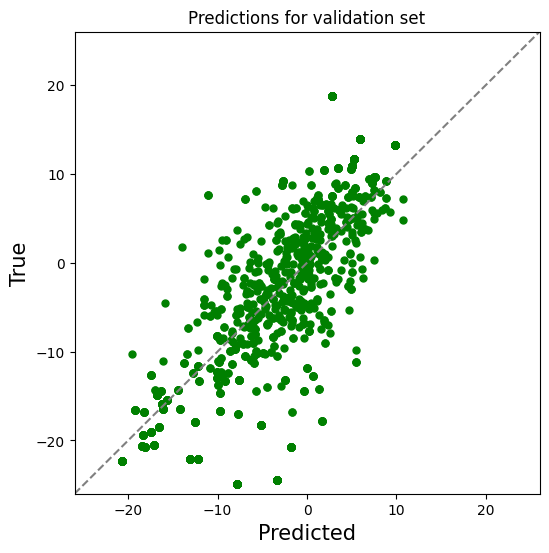

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=25)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('True', size=15)
ax.set_title('Predictions for validation set')

## Validation MSE per position

In [8]:
mn = val['rot'].apply(lambda x: (x[0::2] + x[1::2]) / 2)
l = np.concatenate(res['N_pred'].values)
r = np.concatenate(mn.values).reshape(l.shape)
np.mean((r - l) ** 2)

265.4173583553518

## Validation MSE per sequence

In [9]:
np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

7.770649422732482

## Test on PDB

In [10]:
test_data = pd.read_pickle('../../TCST/hamp_svm/pdb_measure.p')

In [11]:
# mutants deletion
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq'}, inplace=True)
test_data=test_data.drop(['5jeq.pdb',
            '5jef.pdb',
            '3zrv.pdb',
            '2lfs.pdb',
            '3zrw.pdb',
            '3zcc.pdb',
            '2l7i.pdb', '2y20.pdb', '2y21.pdb', '2y0q.pdb',
                    
            '3lnr.pdb', 
                    '4i44.pdb', '4i3m.pdb'

           
           ])
test_data['n_seq'] = test_data['n_seq'].apply(lambda x:x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x:x[1:-1])
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'Predictions for WT HAMPs (with mutants)')

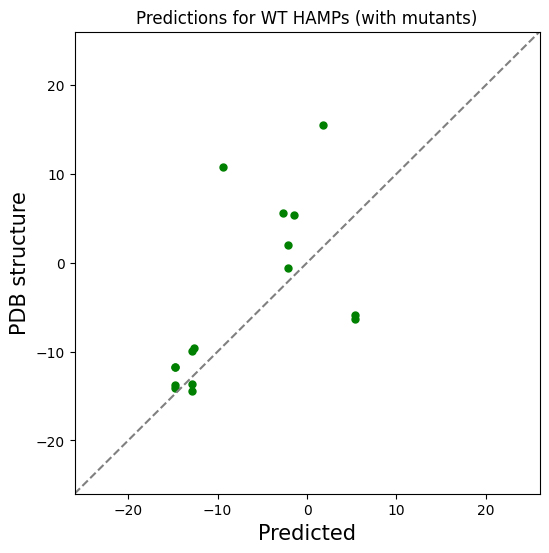

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=25)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('PDB structure', size=15)
ax.set_title('Predictions for WT HAMPs (with mutants)')

## Validation MSE per position

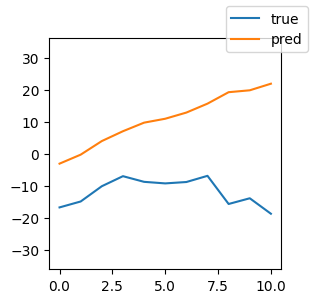

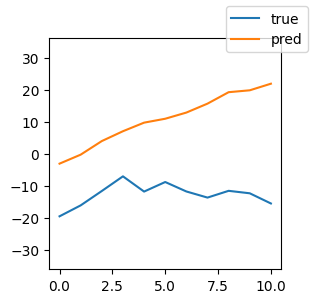

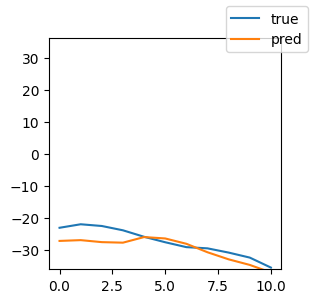

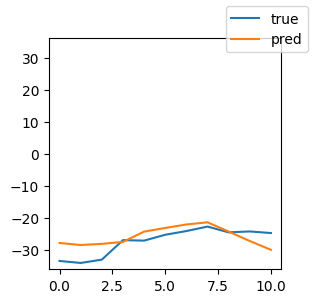

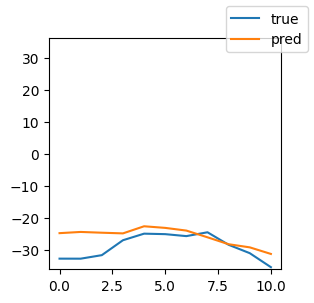

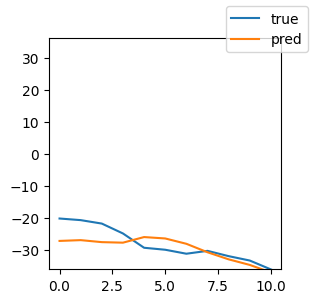

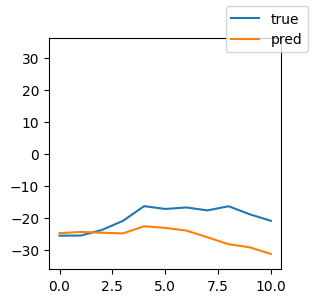

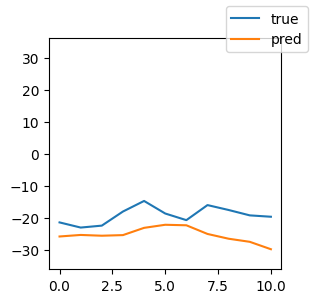

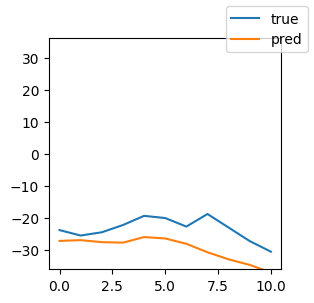

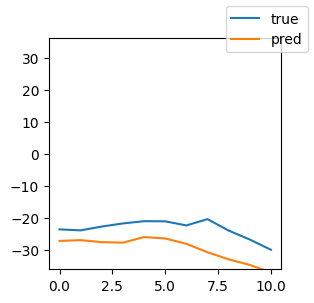

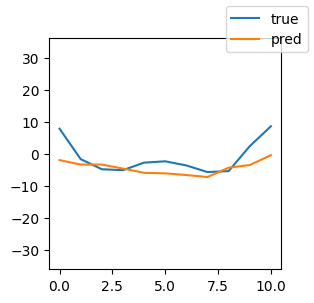

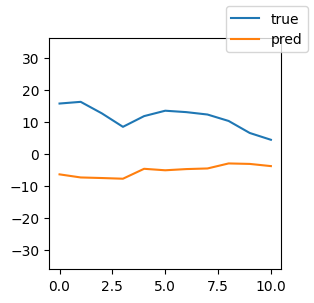

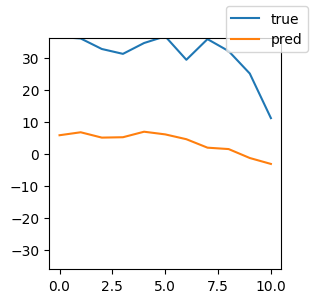

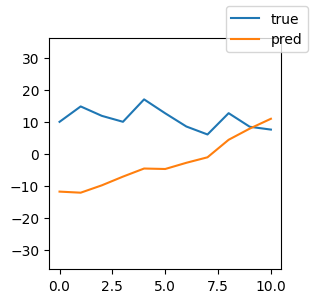

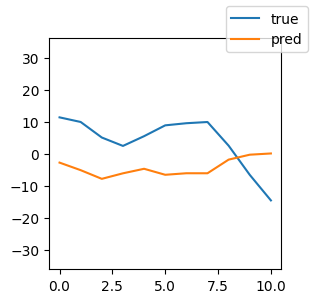

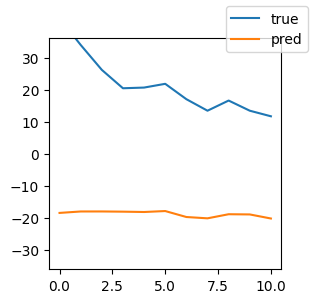

In [13]:
for i in range(len(test_data)):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
    r = test_data.iloc[i]
    tr = (r['rot'][0::2] + r['rot'][1::2]) / 2
    pred = res.iloc[i]['N_pred']
    ax.plot(tr, label='true')
    ax.plot(pred, label='pred')
    ax.set_ylim(-36, 36)
    fig.legend(); pass